In [1]:
import networkx as nx
import matplotlib
%matplotlib inline
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import random
import time

In [ ]:
# ONLY IF COLAB 
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/src/NetworkSyncCapstone

In [2]:
import sys
sys.path.append('./Metropolis/')
sys.path.append('./src')

In [ ]:
# ANALYSINg RESULTS  FROM A WHOLE RUN
#-----------------------

#-------------------------------------------------------------------
# Analyse 'r_ER-100-p0.1-InDegree-NoSelf-RandomW'
#--------------------------------------------------------------------

from metropolisHastings import loadFromPickle

pickleroot = './data/r_ER-100-p0.1-InDegree-NoSelf-RandomW'

result = loadFromPickle(pickleroot=pickleroot, measurenames=['discreteSigma2Analytical','weighted_average_clustering'], gml=False, errorbar=True, title=None, figsize=None)

    # name like r_Gcatu_TSE_up_beta_3000.pkl
    #     E.G. PICKLEROOT='r_Gcatu_TSE_'

In [4]:
# LOADING A BETA
#-------------------
from pickleUtil import pickleLoad

result_beta = pickleLoad('r_FixIn-100-DegIn2-InDegree-NoSelf-FixedW_up_beta_500', './data')
result_beta

Loading object r_FixIn-100-DegIn2-InDegree-NoSelf-FixedW_up_beta_500 from pickle file ./data/r_FixIn-100-DegIn2-InDegree-NoSelf-FixedW_up_beta_500.pkl


{'samples': {'N': [100, 100, 100, 100, 100, 100, 100, 100, 100, 100],
  'L': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200],
  'average_degree': [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0],
  'sigma_z': [1.7944358444926358,
   1.6124515496597103,
   1.7832554500127007,
   1.8547236990991411,
   1.8493242008906934,
   1.8601075237738276,
   1.8814887722226776,
   1.9697715603592207,
   1.897366596101028,
   1.9697715603592207],
  'weighted_average_clustering': [0.03816666666666666,
   0.029904761904761896,
   0.03844841269841269,
   0.03659126984126985,
   0.0414920634920635,
   0.02991666666666666,
   0.03136111111111111,
   0.034888888888888886,
   0.024499999999999997,
   0.03383333333333333],
  'discreteSigma2Analytical': [2224.4185418181964,
   2502.09792993164,
   2502.119303662109,
   2502.2008484374996,
   2502.2168984375003,
   2502.289216406249,
   2502.3077898437496,
   2502.3028562499994,
   2502.3493742187493,
   2502.3719468749996],
  'average_clustering': [0.03

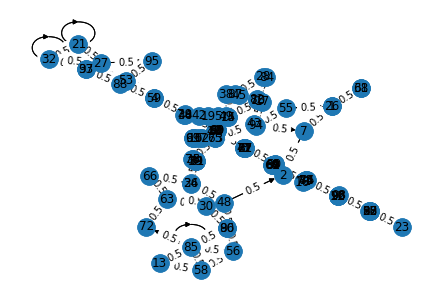

In [5]:
G = result_beta['lastnet']
layout = nx.kamada_kawai_layout(G)
nx.draw(G, layout)
nx.draw_networkx(G, pos=layout)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels)
plt.show()

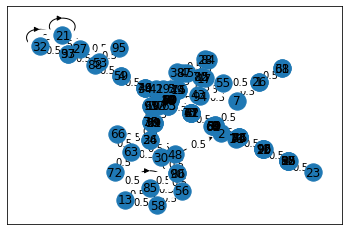

In [6]:
from gvisu import drawCurvedEdgesGraph

drawCurvedEdgesGraph(G)

In [7]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [1]:
import torch
torch.cuda.is_available()

False

In [ ]:
  #-------------------------------------------------------------------
# Analyse 'r_ER-100-p0.1-InDegree-NoSelf-RandomW'
#--------------------------------------------------------------------

from metropolisHastings import loadFromPickle

pickleroot = './data/FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002'

result = loadFromPickle(pickleroot=pickleroot, measurenames=['discreteSigma2Analytical','weighted_average_clustering'], gml=False, errorbar=True, title=None, figsize=None)

    # name like r_Gcatu_TSE_up_beta_3000.pkl
    #     E.G. PICKLEROOT='r_Gcatu_TSE_'

In [61]:
import copy
import networkx as nx
import numpy as np
import random
import pandas as pd
import re
import pickle
from pathlib import Path
from pickleUtil import pickleLoad

def loadSamplesFromPickle(experiment_name, datafolder='./data'):

    # name like r_Gcatu_TSE_up_beta_3000.pkl
    baseUri=Path(datafolder)

    pklFiles=[x for x in baseUri.glob('**/' + experiment_name + '*.pkl')]

    if pklFiles==[]:
        print(f'No files found here {datafolder}/{experiment_name}*.pkl')
        return

    patternBeta = r"beta_(-?[0-9]*)\.pkl"
    patternUp = r"_up_"
    patternStartNet = r"StartNet\.pkl"
    patternBurnin = r"_burnin_(-?[0-9]*)\.pkl"

    data  ={ 'beta': [], 'up': [], 'g': [], 'time':[], 'file':[], 'experiment':[], 'comment':[]}
    #dataDown={ 'beta': [], 'up': [], 'g': [], 'time':[], 'file':[], 'experiment':[], 'comment':[]}

    for i, fn in enumerate(pklFiles):
        
        print('######################################################################################################')
        print(f'Processing file {i}, {fn}')
        print('######################################################################################################')
        
        # Saving initial network 
        if re.search(patternStartNet, fn.name)!= None:
            startNet=True
            result=pickleLoad(str(fn.stem), str(fn.parents[0]), silent=False)
            data['beta'].append(-1)
            data['up'].append(True)
            data['g'].append(result)
            data['time'].append(-1)
            data['file'].append(fn)
            data['experiment'].append(experiment_name)
            data['comment'].append('startNet')
            continue
        
        comment=''
        if re.search(patternBurnin, fn.name)!=None:
        # Reading burning results
            print('Reading burnin file')
            beta = int(re.search(patternBurnin, fn.name).group(1))
            up=True
            comment='burnin'
        else:
        # Reading standard result
            beta=int(re.search(patternBeta, fn.name).group(1))
            up=False
            if re.search(patternUp, fn.name)!= None:
                up=True
            else:
                up=False
              
        print(f'.Beta: {beta}')        
        print(f'.Going up? {up}')

        #loading pickle file
        result=pickleLoad(str(fn.stem), str(fn.parents[0]), silent=True)

        for i, sample in enumerate(result['samples']['g']):

            data['beta'].append(beta)
            data['up'].append(up)
            data['g'].append(sample)
            data['time'].append(i)
            data['file'].append(fn)
            data['experiment'].append(experiment_name)
            data['comment'].append('')

    df = pd.DataFrame(data)
    df = df.sort_values(by=['beta', 'time'])
            
    return df

In [62]:
df_up = loadSamplesFromPickle('r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW', datafolder='./data')

######################################################################################################
Processing file 0, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002_up_beta_100004.pkl
######################################################################################################
.Beta: 100004
.Going up? True
######################################################################################################
Processing file 1, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002_burnin_100000.pkl
######################################################################################################
Reading burnin file
.Beta: 100000
.Going up? True
######################################################################################################
Processing file 2, data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW-002_up_beta_100003.pkl
######################################################################################################
.Beta: 100003
.Going up? True
######

In [63]:
df_up.to_csv('blobby')

In [64]:
df_up.head(50)

,beta,up,g,time,file,experiment,comment
214,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
215,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
216,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
217,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
218,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",4,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
219,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",5,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
220,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",6,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
221,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",7,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
222,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",8,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
223,-100004,False,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",9,data/r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW...,r_FixIn-100-DegIn8-InDegree-NoSelf-FixedW,
